# week2 - 文本数据分析

**姓名：刘泽群 班级：180817 学号：18377240**

## 任务描述

利用python数据结构完成简单的文本分析任务

## 任务目标及要求

1. 提供了中英文两个数据集，见资源/data，分别讨论和分析
2. 一行一条评论或一条tweet
3. 一行可以视为一个文档
4. 读入所有文档并分词（中文需要jieba)
5. 统计词频，找到高频词，过滤停用词，确定特征集（停用词表自行检索并构建，如提供的示例stopwords_list.txt）
6. 利用特征集为每一条评论生成向量表示
7. 计算一下不同评论之间的距离（自定义，如欧氏或余弦），找到所有评论的“重心”或者所有文档中的代表性文档并输出原文。
8. （附加1）能不能实现关键词的词云可视化？(import WordCloud)
9. （附件2）能不能用学过的统计方法进行简单的聚类？
10. 注意：通过函数进行封装，并在main函数中调用；提交的作业报告格式如资源/作业模板示例。

## 报告说明
本报告为Jupyter Notebook直接导出

每个部分用三个cell来表示：代码块、运行结果块、分析说明块 

注：并非所有部分都包含三个cell

In [1]:
# 引入需要使用的库
import requests as rs
import os
import jieba as jb
import pandas as pd
import numpy as np
from wordcloud import WordCloud as wc
import matplotlib.pyplot as plt
import re
import math
from PIL import Image

In [2]:
# 获取数据
def get_data(url):
    '''
    '''
    head = {
        'user-agent':
        'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.130 Safari/537.36'
    }
    response = rs.get(url, headers=head)
    return response.text.strip().split('\n')

url_list = {
    'online_reviews_texts':r'https://course.e2.buaa.edu.cn/access/content/group/6095b6c8-3c07-4799-ba79-dc9e5a379db6/data/online_reviews_texts.txt',
    'stopwords_list':r'https://course.e2.buaa.edu.cn/access/content/group/6095b6c8-3c07-4799-ba79-dc9e5a379db6/data/stopwords_list.txt',
    'tweets_apple_stock':r'https://course.e2.buaa.edu.cn/access/content/group/6095b6c8-3c07-4799-ba79-dc9e5a379db6/data/tweets_apple_stock.txt'
}

ort = get_data(url_list['online_reviews_texts'])
sl = get_data(url_list['stopwords_list'])
tas = get_data(url_list['tweets_apple_stock'])

# 输出末尾看看是不是
print(ort[-1],sl[-1],tas[-1],sep = '\n\n')

今年礼券卡和现货买了十几份，但是收到的螃蟹却五花八门，什么品质的都有，完全是靠缘分吃蟹、而不是按照实际的花出去的钱换来同样品质的蟹，另外商家客服总是不回复、不解决，鉴于商家如此欺骗消费者的行为及不作为的态度，差评、差评、差评，绝对差评！阳澄湖的水以清著称，养出来的蟹咋就那也脏呢，洗都洗不掉，就跟在蓄水池里养的一样，实在没法吃！

+

RT @11Graphs: EV-to-EBITDA (ttm):1. 🇺🇸 Microsoft $MSFT 16.352. 🇺🇸 Apple $AAPL 10.733. 🇺🇸 Amazon $AMZN 25.324. 🇺🇸 Alphabet $GOOG 13.405…


数据的获取部分并没有选择从本地直接读入，而是从网站上爬取，由于均为txt文件，故没有使用bs4等专业的爬虫库，直接用requests抓取源码即可。

当然我也下载文件到了本地，也可以通过文件io进行读取

运行结果展示的是每个文件最后几行话（为了确保爬取到了全部的内容）

In [3]:
# 处理文本 包括中英文去标点符号 英文去大小写等
def process_data(data):
    '''
    '''
    punctuation = '''`~!@#$%^&*()-=_+\[\]{}|;:,.<>/?·！￥……（）【】‘“《》，。、？"：；～'\\ '''
    for i in range(len(data)):
        data[i] = re.sub(r'[{}]+'.format(punctuation),' ',data[i]).lower()
    return data

ort_ap = process_data(ort)
tas_ap = process_data(tas)

print(ort_ap[-1],tas_ap[-1],sep = '\n\n')

今年礼券卡和现货买了十几份 但是收到的螃蟹却五花八门 什么品质的都有 完全是靠缘分吃蟹 而不是按照实际的花出去的钱换来同样品质的蟹 另外商家客服总是不回复 不解决 鉴于商家如此欺骗消费者的行为及不作为的态度 差评 差评 差评 绝对差评 阳澄湖的水以清著称 养出来的蟹咋就那也脏呢 洗都洗不掉 就跟在蓄水池里养的一样 实在没法吃 

rt graphs ev to ebitda ttm 🇺🇸 microsoft msft 🇺🇸 apple aapl 🇺🇸 amazon amzn 🇺🇸 alphabet goog 


利用正则表达式将所有标点换成空格，以便后期的分词处理和词云的绘制

运行结果展示的是去除标点之后的文本

In [4]:
# 分词并写入文件
def every_cut(cut_list,language = 'Chinese',to_file = ''):
    '''
    '''
    res = []
    if language == 'Chinese':
        for i in cut_list:
            temp = []
            for j in jb.cut(i, cut_all=True):
                if j not in ['',' ']:
                    temp.append(j)
            res.append(temp)
    elif language == 'English':
        for i in cut_list:
            res.append(i.split())
    else:
        print('Try again!')
        return -1
    if to_file:
        with open(to_file,'w',encoding='unicode-escape') as f:
            for i in res:
                f.write(','.join(i))
    return res

def all_cut(cut_list,language = 'Chinese',to_file = ''):
    '''
    '''
    res = []
    if language == 'Chinese':
        temp = []
        for i in cut_list:
            temp.extend(jb.cut(i, cut_all=True))
        for i in temp:
            if i not in ['',' ']:
                res.append(i)
    elif language == 'English':
        for i in cut_list:
            res.extend(i.split())
    else:
        print('Try again!')
        return -1
    if to_file:
        with open(to_file,'w',encoding='unicode-escape') as f:
            f.write(','.join(res))
    return res

ort_cut = all_cut(ort_ap,to_file = r'.\data\ort_cut.csv')
tas_cut = all_cut(tas_ap,'English',to_file = r'.\data\tas_cut.csv')
ort_cut_eve = every_cut(ort_ap,to_file = r'.\data\ort_cut_eve.csv')
tas_cut_eve = every_cut(tas_ap,'English',to_file = r'.\data\tas_cut_eve.csv')
print(ort_cut[-100:],tas_cut[-100:],sep = '\n\n')
print(ort_cut_eve[-1],tas_cut_eve[-1],sep = '\n\n')

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\11973\AppData\Local\Temp\jieba.cache
Loading model cost 0.685 seconds.
Prefix dict has been built successfully.
['几份', '但是', '收到', '的', '螃蟹', '却', '五花', '五花八门', '八门', '什么', '品质', '的', '都', '有', '完全', '是', '靠', '缘分', '吃', '蟹', '而', '不是', '按照', '照实', '实际', '的', '花', '出去', '的', '钱', '换来', '同样', '样品', '品质', '的', '蟹', '另外', '外商', '商家', '客服', '总是', '不', '回复', '不解', '解决', '鉴于', '商家', '如此', '欺骗', '消费', '消费者', '的', '行为', '及', '不作', '作为', '的', '态度', '差', '评', '差', '评', '差', '评', '绝对', '差', '评', '阳澄湖', '的', '水', '以', '清', '著称', '养', '出来', '的', '蟹', '咋', '就', '那', '也', '脏', '呢', '洗', '都', '洗不掉', '不掉', '就', '跟', '在', '蓄水', '蓄水池', '水池', '池里', '养', '的', '一样', '实在', '没法', '吃']

['midday', 'adbe', 'aapl', 'fb', 'sedg', 'neo', 'oled', 'coup', 'zs', 'lulu', 'shop', 'noc', 'now', 'payc', 'gpn', 'ayx', 'with', 'current', 'earnings', 'report', 'amp', 'economic', 'conditions', 'it', 'could', 'be', 'a', 'while', 'before', '

利用jieba库进行分词

为了后期统计关键词更加精准，分词的时候选择了精确模式

运行结果为分词结果

但还是感觉有些问题：比如我分词之后，“不喜欢”被分成了“不”和“喜欢”，这样的话感情倾向就变了。

In [5]:
# 统计词频 词频以TF（Term Frequency）策略统计
# 词频（TF）= 某个词在文章中的出现次数 / 文章的总词数
def refresh_stopwords_list():
    with open(r'.\data\stopwords_list.txt','r') as f:
        sl = f.read().strip().split('\n')
    return sl

def statistical_frequency_TF(data):
    res_dict = {}
    for i in data:
        if i not in sl:
            res_dict[i] = res_dict.get(i,0) + 1
    for i in res_dict.keys():
        res_dict[i] = res_dict[i]/len(data)
    return pd.DataFrame({'TF':res_dict})

sl = refresh_stopwords_list()
ort_fre_tf = statistical_frequency_TF(ort_cut)
tas_fre_tf = statistical_frequency_TF(tas_cut)

ort_fre_tf

,TF
app,0.000038
black,0.000013
blalala,0.000013
bpl,0.000013
cnm,0.000013
...,...
鼻子,0.000025
鼻孔,0.000013
龙虾,0.000175
龚,0.000013


In [6]:
tas_fre_tf

,TF
aa,0.000196
aaaarrghhh,0.000013
aaamportfolios,0.000013
aabb,0.000052
aaguf,0.000013
...,...
🥉,0.000026
🥉apple,0.000026
🥉ht,0.000013
🥉https,0.000052


首先通过停用词表进行无用词的过滤，我感觉老师给的表对英文停用不是很友好，所以我在网上又找了一个，因此这一部分将停用词表重新读入了。

利用tf方式统计词频，这里的词频并非传统意义的词频，而是该词在文章中的重要程度
我觉得传统词频统计方式并不能展现某个词的重要性，比如‘我’几乎所有文本都会出现，但绝大多数情况下其都不是一个重要的词汇。
为了避免这种现象的出现，我选择使用tf算法进行词频统计，结果如图。

In [7]:
# 找到高频词 确定特征集
# 考虑到特征集并非词频越高越好 因此使用TF—IDF算法找到高频词并确定特征集
# 逆文档频率（IDF） = log(语料库的文档总数 / （包含该词的文档数+1）)
# TF-IDF = TF * IDF
def statistical_frequency_IDF(data_df,data_ap):
    '''
    '''
    res_dict = {}
    nums = len(data_ap) # 语料总条数
    for row in data_df.itertuples():
        name = row[0]
        temp = 0
        for i in data_ap:
            if name in i:
                temp += 1
        res_dict[name] = temp
    for i in res_dict.keys():
        res_dict[i] = math.log(nums/(res_dict[i] + 1))
    data_df['IDF'] = res_dict.values()
    return data_df
    

def find_feature_sets_by_TFIDF(df):
    '''
    '''
    res = []
    for row in df.itertuples():
        res.append(row[1]*row[2])
    df['TF-IDF'] = res
    return df

ort_fre_idf = statistical_frequency_IDF(ort_fre_tf,ort_ap)
tas_fre_idf = statistical_frequency_IDF(tas_fre_tf,tas_ap)

ort_fre_tfidf = find_feature_sets_by_TFIDF(ort_fre_idf)
tas_fre_tfidf = find_feature_sets_by_TFIDF(tas_fre_idf)

ort_fre_tfidf

,TF,IDF,TF-IDF
app,0.000038,6.173091,0.000232
black,0.000013,6.578557,0.000082
blalala,0.000013,6.578557,0.000082
bpl,0.000013,6.578557,0.000082
cnm,0.000013,6.578557,0.000082
...,...,...,...
鼻子,0.000025,6.173091,0.000155
鼻孔,0.000013,6.578557,0.000082
龙虾,0.000175,5.325794,0.000933
龚,0.000013,6.578557,0.000082


In [8]:
tas_fre_tfidf

,TF,IDF,TF-IDF
aa,0.000196,0.156208,0.000031
aaaarrghhh,0.000013,7.313554,0.000096
aaamportfolios,0.000013,7.313554,0.000096
aabb,0.000052,6.397263,0.000335
aaguf,0.000013,7.313554,0.000096
...,...,...,...
🥉,0.000026,5.608806,0.000147
🥉apple,0.000026,6.908089,0.000181
🥉ht,0.000013,6.214941,0.000081
🥉https,0.000052,6.397263,0.000335


找到高频词、确定特征集

为了避免非重要的词进入特征集，本文采用tf-idf算法来进行特征集的筛选

首先计算所有词的tf-idf得分，再选取得分最高的100个词作为特征集（本来想选更多的，但无奈算力不足，只好选了100个）

In [9]:
# 确定特征集
# 取tfidf得分最高的前100个词作为特征集
def select_characteristic(df):
    df = df.sort_values(by = 'TF-IDF',ascending = False)
    return df.head(100)

ort_cha = select_characteristic(ort_fre_tfidf)
tas_cha = select_characteristic(tas_fre_tfidf)

ort_cha

,TF,IDF,TF-IDF
螃蟹,0.009599,1.180394,0.011331
客服,0.005720,1.662232,0.009507
商家,0.004193,1.953584,0.008191
死,0.005532,1.422379,0.007868
买,0.011489,0.673195,0.007734
...,...,...,...
建议,0.000701,3.282720,0.002301
缺斤少两,0.000651,3.510504,0.002285
礼券,0.000588,3.870506,0.002277
商品,0.000663,3.421556,0.002270


In [10]:
tas_cha

,TF,IDF,TF-IDF
https,0.027371,0.537617,0.014715
amzn,0.010603,1.315859,0.013952
fb,0.009503,1.406830,0.013370
spy,0.007056,1.715132,0.012101
apple,0.006218,1.860372,0.011567
...,...,...,...
sbux,0.000707,3.999368,0.002827
yuan,0.000694,4.017717,0.002787
active,0.000707,3.929163,0.002777
nq,0.000785,3.529364,0.002772


上述结果即为特征集和相应的tf-idf得分

In [11]:
# 利用特征集 为每条评论生成向量
# 依然使用tf-idf算法
def doc2tfidf_matrix(vocab, words_list,to_file = ''):
    '''
    '''
    # 建立一个M行V列的全0矩阵，M是文档样本数，这里是行数，V为不重复词语数，即编码维度
    V = len(vocab)
    M = len(words_list)
    onehot = np.zeros((M,V)) # 二维矩阵要使用双括号
    tf = np.zeros((M,V))
    
    for i,doc in enumerate(words_list):
        for word in doc:
            if word in vocab:
                pos = vocab.index(word)
                onehot[i][pos] = 1
                tf[i][pos] += 1 # tf,统计某词语在一条样本中出现的次数
    
    row_sum = tf.sum(axis=1) # 行相加，得到每个样本出现的词语数
    # 计算TF(t,d)
    tf = tf/row_sum[:, np.newaxis] #分母表示各样本出现的词语数，tf为单词在样本中出现的次数，[:,np.newaxis]作用类似于行列转置
    # 计算DF(t,D)，IDF
    df = onehot.sum(axis=0) # 列相加，表示有多少样本包含词袋某词
    idf = list(map(lambda x:math.log10((M+1)/(x+1)),df))
    # 计算TFIDF
    tfidf = tf*np.array(idf)
    tfidf = pd.DataFrame(tfidf,columns=vocab)
    if to_file:
        tfidf.to_csv(to_file)
    return tfidf

ort_vec = doc2tfidf_matrix(ort_cha._stat_axis.values.tolist(),ort_cut_eve,to_file = r'.\data\ort_vec.csv')
tas_vec = doc2tfidf_matrix(tas_cha._stat_axis.values.tolist(),tas_cut_eve,to_file = r'.\data\ort_vec.csv')

ort_vec

,螃蟹,客服,商家,死,买,吃,差,母,恶心,两,...,自营,扔,市场,退款,送到,建议,缺斤少两,礼券,商品,太差
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.104575,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.095861,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0
2,0.064118,0.000000,0.000000,0.000000,0.029632,0.023965,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.061928,0.0
3,0.000000,0.000000,0.032644,0.000000,0.000000,0.022122,0.000000,0.000000,0.025228,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0
4,0.085490,0.000000,0.000000,0.000000,0.118530,0.000000,0.054775,0.070728,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1434,0.000000,0.000000,0.000000,0.145362,0.000000,0.082166,0.000000,0.000000,0.000000,0.000000,...,0.0,0.096104,0.0,0.0,0.0,0.101855,0.0,0.000000,0.000000,0.0
1435,0.000000,0.000000,0.000000,0.000000,0.059265,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0
1436,0.000000,0.000000,0.000000,0.226119,0.000000,0.000000,0.000000,0.000000,0.109323,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0
1437,0.020518,0.000000,0.033949,0.000000,0.028447,0.000000,0.000000,0.067899,0.026237,0.153114,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0


In [12]:
tas_vec

,https,amzn,fb,spy,apple,nflx,tsla,msft,googl,rt,...,august,money,war,markets,traders,sbux,yuan,active,nq,iphone
0,0.049392,0.114756,0.000000,0.149487,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.000000,0.000000,0.077510,0.093430,0.000000,0.000000,0.000000,0.116051,0.114688,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.214248,0.0
2,0.082321,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.049392,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.024696,0.057378,0.062008,0.000000,0.000000,0.081371,0.000000,0.000000,0.091750,0.043523,...,0.0,0.000000,0.163231,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2996,0.041160,0.047815,0.000000,0.000000,0.000000,0.067809,0.000000,0.077367,0.000000,0.000000,...,0.0,0.000000,0.000000,0.140418,0.0,0.0,0.0,0.0,0.000000,0.0
2997,0.000000,0.000000,0.206693,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.145076,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
2998,0.000000,0.028689,0.031004,0.037372,0.000000,0.040685,0.045995,0.046420,0.000000,0.000000,...,0.0,0.082893,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
2999,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.309469,0.000000,0.145076,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0


利用特征集 为每条评论生成向量

文本转向量 这里使用的算法依然是tf-idf算法，词袋是特征集

运行结果是每天评论的向量表示（100维）

In [45]:
# 计算距离并找到重心

def calculate_distance(vec_df,fuc = '欧式距离',to_file = ''):
    '''
    '''
    LEN = vec_df.shape[0]
    res = [[0 for _ in range(LEN)] for __ in range(LEN)]
    for i in range(LEN):
        for j in range(i):
            res[i][j] = math.sqrt(sum((vec_df.loc[i] - vec_df.loc[j])**2))
    res = pd.DataFrame(res)
    if to_file:
        res.to_csv(to_file)
    return res

def find_heart(vec_df,odata):
    '''
    '''
    heart = vec_df.mean(axis = 0)
    min_index = -1
    min_num = 99999
    for i in range(vec_df.shape[0]):
        temp = math.sqrt(sum((vec_df.loc[i] - heart)**2))
        if temp <= min_num:
            min_num = temp
            min_index = i
    return odata[min_index]

    

ort_dis = calculate_distance(ort_vec,to_file = r'.\data\ort_dis.csv')
tas_dis = calculate_distance(tas_vec,to_file = r'.\data\tas_dis.csv')

print(ort_dis.head())
print(tas_dis.head())

ort_heart = find_heart(ort_vec,ort)
tas_heart = find_heart(tas_vec,tas)

print(ort_heart)
print(tas_heart)

0         1         2         3     4     5     6     7     8     9     \
0  0.000000  0.000000  0.000000  0.000000   0.0   0.0   0.0   0.0   0.0   0.0   
1  0.420669  0.000000  0.000000  0.000000   0.0   0.0   0.0   0.0   0.0   0.0   
2  0.410233  0.440652  0.000000  0.000000   0.0   0.0   0.0   0.0   0.0   0.0   
3  0.436843  0.518824  0.366512  0.000000   0.0   0.0   0.0   0.0   0.0   0.0   
4  0.356312  0.474609  0.356250  0.404269   0.0   0.0   0.0   0.0   0.0   0.0   

   ...  1429  1430  1431  1432  1433  1434  1435  1436  1437  1438  
0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0     0  
1  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0     0  
2  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0     0  
3  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0     0  
4  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0     0  

[5 rows x 1439 columns]
       0         1         2         3     4     5     6     7     8     9     \


计算距离矩阵

利用欧氏距离进行计算，100维的情况下计算两两评论的距离大概需要20分钟的时间...我的算力实在不允许我计算更高维的距离了

重心求法类似三角形的重心求法，计算每个向量的平均值。

找到重心后并未输出，而是进一步找到距离重心最近的一条文本输出的，作为整个文章的代表

但输出后才发现，距离重心最近的文本，并没有突出的关键词（正是因为这个才最近的），反而不能很好的代表正文章。

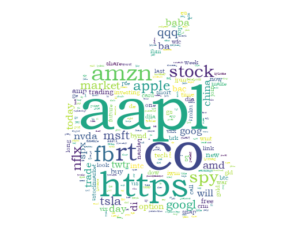

In [93]:
# 实现词云可视化
%matplotlib inline
def show_worldcloud(cut_list,bgp = '',to_file = ''):
    '''
    '''
    if bgp:
        mask = np.array(Image.open(bgp))
    else:
        mask = None
    wc_ = wc(font_path='C:\Windows\Fonts\STZHONGS.TTF',  # 设置字体
            background_color="white",  # 背景颜色
            max_words=1000,  # 词云显示的最大词数
            random_state=42, #随机数
            collocations=False, #避免重复单词
            mask = mask,
            ).generate(" ".join(cut_list))
    plt.imshow(wc_, interpolation='bilinear')
    plt.axis("off") #隐藏坐标
    if to_file:
        wc_.to_file(to_file)

show_worldcloud(ort_cut,bgp = r'./img/pangxie_bgp.jpg',to_file = r'.\img\ort_cloud.png')


In [ ]:
show_worldcloud(tas_cut,bgp = r'./img/pingguo.jpg',to_file = r'.\img\tas_cloud.png')

生成词云 分别使用螃蟹和苹果做蒙板

致歉：这次作业完成的有些仓促，虽然时间很长，但开学来手头的事情非常多，导致没有分配给这个作业太多时间。最后的效果也不是我想要的，如果后期有时间我会对本次作业进行完善和补充

flag：经过思考，我在此立下本学期大作业的flag，大作业代码量5000+，使用深度学习算法进行辅助分析，完全在Linux系统上进行开发，请老师监督。